In [28]:
# importing necessary libraries
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')


In [3]:
## loading Wyscout Data

folder_path = '/Users/pratikhotchandani/Downloads/Github/DataScience_Football/WyscoutData'

In [4]:
england_event_file = "/Users/pratikhotchandani/Downloads/Github/DataScience_Football/WyscoutData/events/events_England.json"
with open(england_event_file) as f:
    data = json.load(f)
    df_england_events = pd.DataFrame(data)

train = df_england_events

In [5]:
# Preparing shot angle and distance data

In [6]:
shots = train.loc[train['subEventName'] == 'Shot']

#get shot coordinates as separate columns
shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)
#calculate distance and angle
shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
#if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object
shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)

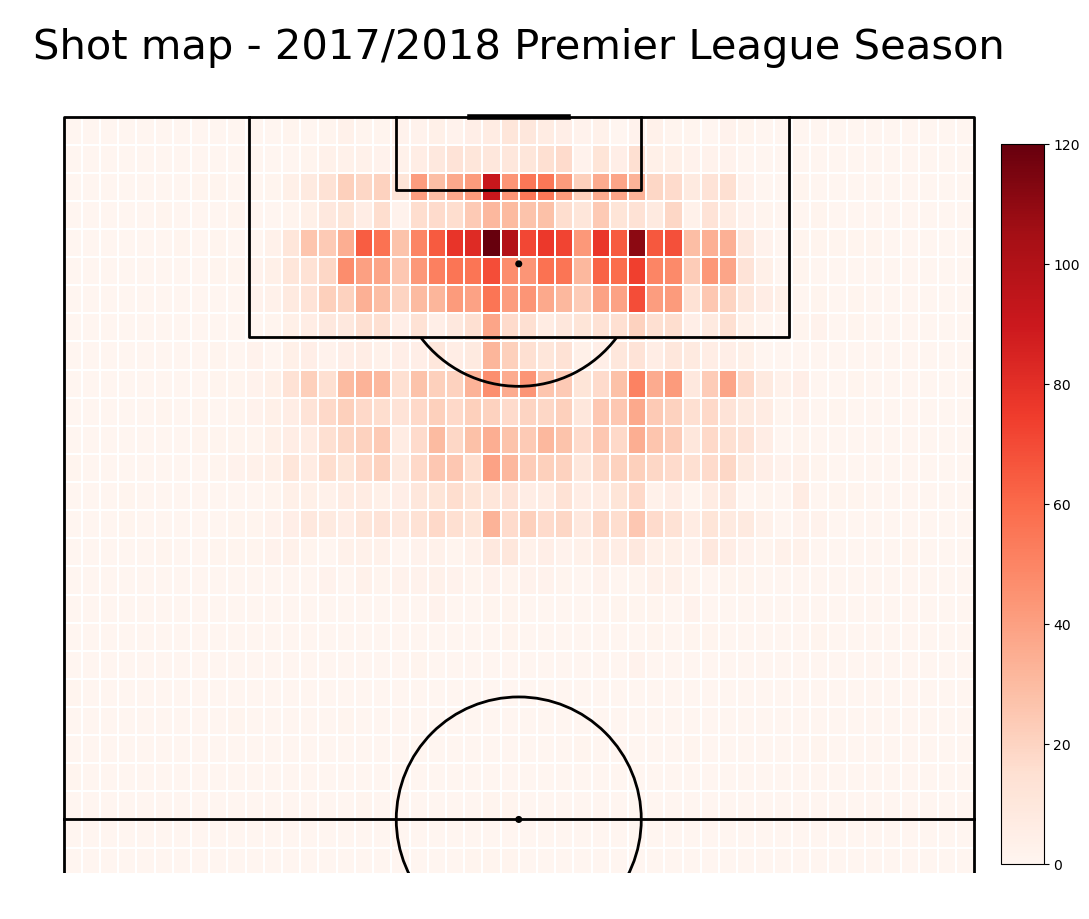

In [7]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#subtracting x from 105 but not y from 68 because of inverted Wyscout axis
#calculate number of shots in each bin
bin_statistic_shots = pitch.bin_statistic(105 - shots.X, shots.Y, bins=50)
#make heatmap
pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)
#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot map - 2017/2018 Premier League Season' , fontsize = 30)
plt.show()

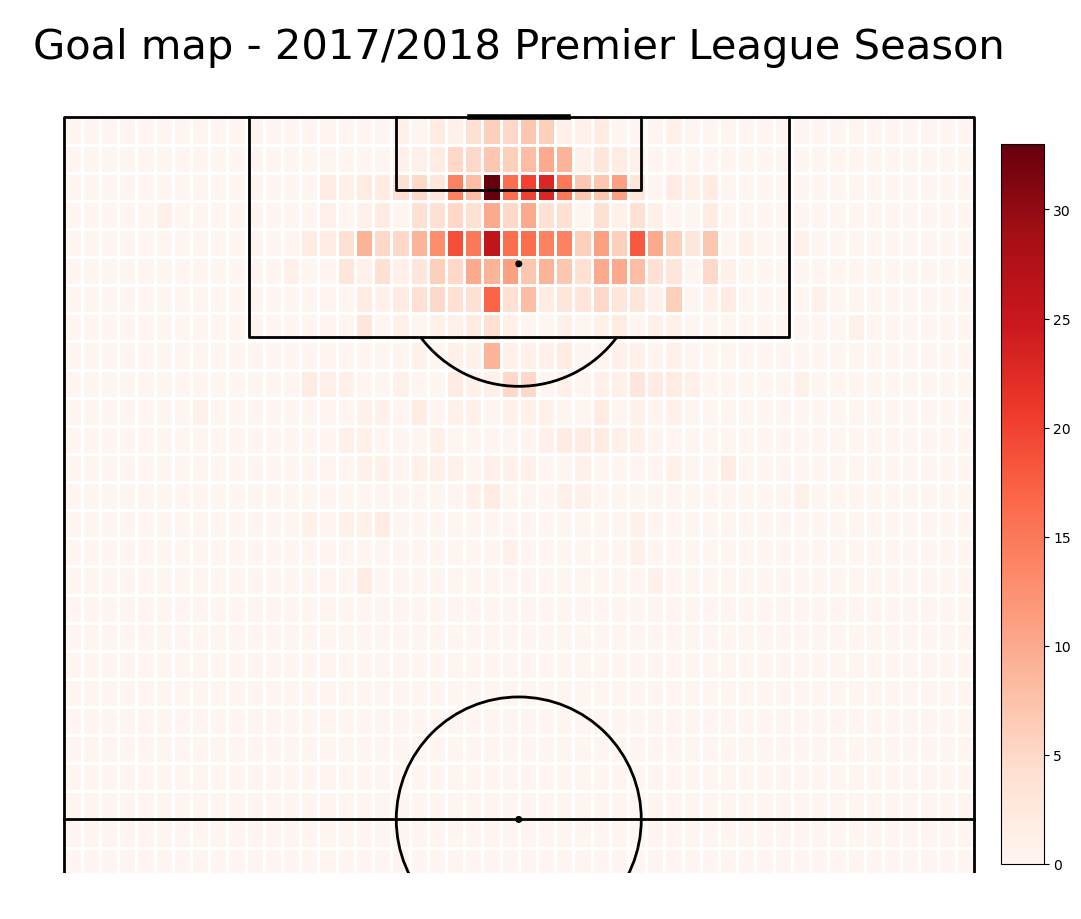

In [8]:
#take only goals
goals = shots.loc[shots["Goal"] == 1]
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#calculate number of goals in each bin
bin_statistic_goals = pitch.bin_statistic(105 - goals.X, goals.Y, bins=50)
#plot heatmap
pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap='Reds', edgecolor='white')
#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal map - 2017/2018 Premier League Season' , fontsize = 30)
plt.show()

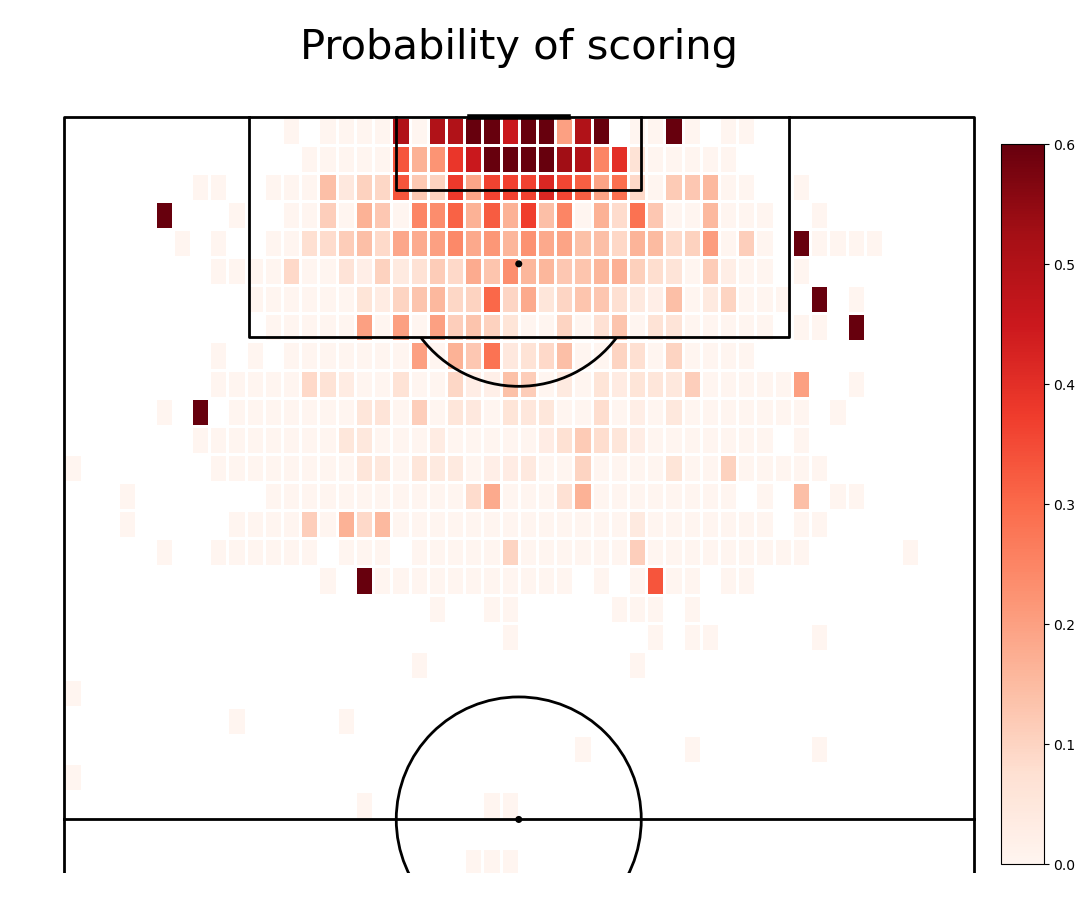

In [9]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
bin_statistic = pitch.bin_statistic(105 - shots.X, shots.Y, bins = 50)
#normalize number of goals by number of shots
bin_statistic["statistic"] = bin_statistic_goals["statistic"]/bin_statistic["statistic"]
#plot heatmap
pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', vmin = 0, vmax = 0.6)
#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Probability of scoring' , fontsize = 30)
plt.show()

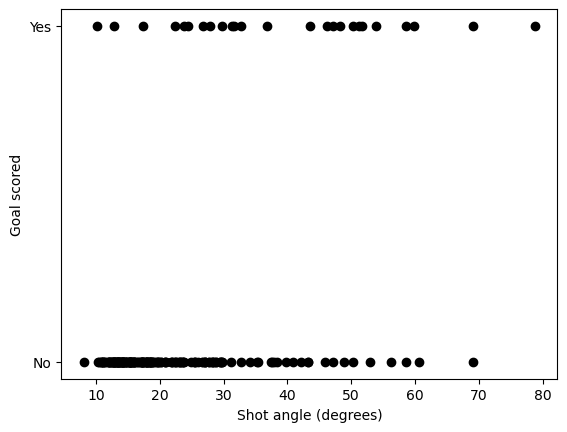

In [10]:
#first 200 shots
shots_200=shots.iloc[:200]
#plot first 200 shots goal angle
fig, ax = plt.subplots()
ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker= '.', markersize= 12, color='black')
#make legend
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

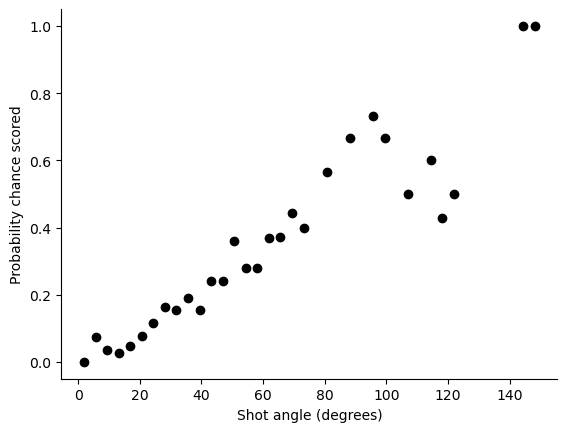

In [11]:
#number of shots from angle
shotcount_dist = np.histogram(shots['Angle']*180/np.pi, bins=40, range=[0, 150])
#number of goals from angle
goalcount_dist = np.histogram(goals['Angle']*180/np.pi, bins=40, range=[0, 150])
np.seterr(divide='ignore', invalid='ignore')
#probability of scoring goal
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
angle = shotcount_dist[1]
midangle = (angle[:-1] + angle[1:])/2
#make plot
fig,ax = plt.subplots()
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [12]:
shots

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,X,Y,C,Distance,Angle,Goal
46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,12.60,27.88,6.12,14.007655,0.467241,1
62,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,100,177959247,15.75,35.36,1.36,15.808608,0.453557,0
91,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,254.745027,100,177959280,4.20,35.36,1.36,4.414703,1.375115,1
128,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,100,177959289,19.95,22.44,11.56,23.057235,0.274666,0
249,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,100,177959429,26.25,20.40,13.60,29.563872,0.219665,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642945,10,Shot,"[{'id': 401}, {'id': 1212}, {'id': 1802}]",8561,"[{'y': 45, 'x': 72}, {'y': 0, 'x': 0}]",2500098,Shot,1633,2H,1972.969422,100,251596053,29.40,30.60,3.40,29.595946,0.244517,0
643023,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",41174,"[{'y': 33, 'x': 86}, {'y': 0, 'x': 0}]",2500098,Shot,1633,2H,2193.887080,100,251596096,14.70,22.44,11.56,18.700898,0.309646,1
643051,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1201}, {'id'...",7879,"[{'y': 62, 'x': 88}, {'y': 100, 'x': 100}]",2500098,Shot,1623,2H,2377.197700,100,251596357,12.60,42.16,8.16,15.011516,0.410444,0
643055,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1206}, {'id'...",145692,"[{'y': 38, 'x': 92}, {'y': 100, 'x': 100}]",2500098,Shot,1623,2H,2381.481625,100,251596359,8.40,25.84,8.16,11.710918,0.461143,0


In [13]:
X = shots[['Distance','Angle']]
y = shots['Goal']

In [14]:

# Assuming you have an array called 'data'
binary_data = np.array(y, dtype=bool)

### Fitting logistic regression model

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [16]:
model = LogisticRegression()

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, binary_data, test_size=0.2, random_state=42)

In [18]:
X

,Distance,Angle
46,14.007655,0.467241
62,15.808608,0.453557
91,4.414703,1.375115
128,23.057235,0.274666
249,29.563872,0.219665
...,...,...
642945,29.595946,0.244517
643023,18.700898,0.309646
643051,15.011516,0.410444
643055,11.710918,0.461143


In [19]:
model.fit(X_train, y_train)


LogisticRegression()

In [20]:
y_pred = model.predict(X_test)


In [21]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8976936723832052


In [22]:

# Obtain the coefficient and intercept values
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [[-0.10037314  1.11636207]]
Intercept: [-1.14410485]


In [23]:
coefficients

array([[-0.10037314,  1.11636207]])

#### Testing model fit

In [27]:
#Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[1504    5]
 [ 168   14]]


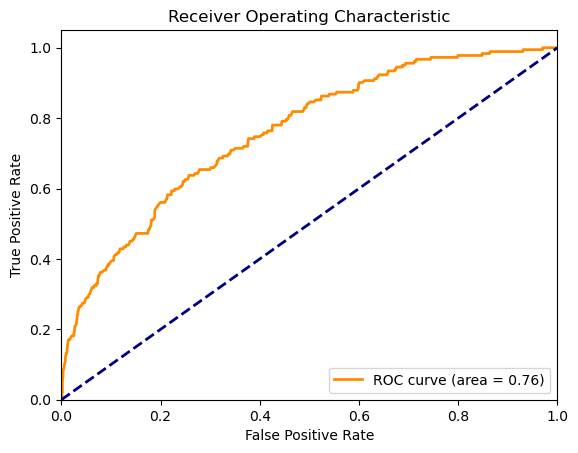

In [29]:
# Make predictions on the test set
y_scores = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [30]:
# Compute the log-likelihood of the full model
ll_full = model.score(X_train, y_train)

# Create a null model with only an intercept term
null_model = LogisticRegression()
null_model.fit(np.ones((len(X_train), 1)), y_train)

# Compute the log-likelihood of the null model
ll_null = null_model.score(np.ones((len(X_train), 1)), y_train)

# Compute McFadden's R-squared
mcfaddens_r2 = 1 - (ll_full / ll_null)

print("McFadden's R-squared:", mcfaddens_r2)

McFadden's R-squared: -0.0031519575315197557
